In [1]:
import argparse
import os

import cv2
import math
import numpy as np
import moviepy 
from matplotlib import pyplot as plt


import torch

from alphaction.config import cfg
from alphaction.dataset import make_data_loader
from alphaction.engine.inference import inference
from alphaction.modeling.detector import build_detection_model
from alphaction.utils.checkpoint import ActionCheckpointer
from torch.utils.collect_env import get_pretty_env_info
from alphaction.utils.comm import synchronize, get_rank
from alphaction.utils.logger import setup_logger
#pytorch issuse #973
import resource


from my_utils.gen_utils import create_experiment_folder


### 1. CONFIG

In [2]:
model_name = 'VMAEv2'
video_path = '../input_dir/markt2_fight.mp4'


person_threshold = 0.8 # confidence threshold on actor. 0.6 is the defualt
sampling_rate = 3 # sampling rate: 4 is the defualt
top_k = 5 # number of actions per person

if model_name == 'VMAEv2':
    config_file = '../config_files/VMAEv2-ViTB-16x4.yaml'
    model_checkpoint = '../checkpoints/VMAEv2_ViTB_16x4.pth'
if model_name == 'VMAE':
    config_file = '../config_files/VMAE-ViTB-16x4.yaml'
    model_checkpoint = '../checkpoints/VMAE_ViTB_16x4.pth'

    

In [3]:
video_name = os.path.basename(video_path).split('.')[0]
output_directory = f'../output_dir/{video_name}/{model_name}/single_patch/' 
output_directory = create_experiment_folder(output_directory, 'exp')
output_directory

'../output_dir/markt2_fight/VMAEv2/single_patch/exp_1'

#### 1.1 Config construction

In [4]:
cfg.merge_from_file(config_file)

In [5]:
# change model weight path
cfg.merge_from_list(["MODEL.WEIGHT", "../checkpoints/VMAEv2_ViTB_16x4.pth"])

# change output dir
cfg.merge_from_list(["OUTPUT_DIR", "../output_dir/"])

# change person threshold
cfg.merge_from_list(["MODEL.STM.PERSON_THRESHOLD", person_threshold])

# change sampling rate
cfg.merge_from_list(["DATA.SAMPLING_RATE", sampling_rate])

# change path for data_dir
cfg.merge_from_list(["DATA.PATH_TO_DATA_DIR", "/work/ava"])

# folder name of annotations
cfg.merge_from_list(["AVA.ANNOTATION_DIR", "annotations/"])

# file name of  frame_lists
cfg.merge_from_list(["AVA.TRAIN_LISTS", ['sample.csv']])
cfg.merge_from_list(["AVA.TEST_LISTS", ['sample.csv']])

# file name of predicted_bboxes
cfg.merge_from_list(["AVA.TRAIN_GT_BOX_LISTS", ['ava_sample_predicted_boxes.csv']])
cfg.merge_from_list(["AVA.TEST_GT_BOX_LISTS", ['ava_sample_predicted_boxes.csv']])

# file name of exlusions
cfg.merge_from_list(["AVA.EXCLUSION_FILE", 'ava_sample_train_excluded_timestamps_v2.2.csv'])

# number of batches in test scenario
cfg.merge_from_list(["TEST.VIDEOS_PER_BATCH", 1])

# number of workers
cfg.merge_from_list(["DATALOADER.NUM_WORKERS", 1])


### 2. ARGS

In [6]:
debug = True
if debug:
    
    # The shape of model input should be divisible into this. Otherwise, padding 0 to left and bottum. 
    print("cfg.DATALOADER.SIZE_DIVISIBILITY: ", cfg.DATALOADER.SIZE_DIVISIBILITY)
    
    # Sampling rate in constructing the clips.
    self_sample_rate =  cfg.DATA.SAMPLING_RATE
    print("cfg.DATA.SAMPLING_RATE: ", cfg.DATA.SAMPLING_RATE)
    
    # Length of clip
    self_video_length = cfg.DATA.NUM_FRAMES
    print("cfg.DATA.NUM_FRAMES: ", cfg.DATA.NUM_FRAMES)
    
    # Length of sequence frames from which a clip is constructed.
    self_seq_len = self_video_length * self_sample_rate
    print("self_seq_len: ", self_seq_len)
    
    self_num_classes = cfg.MODEL.STM.ACTION_CLASSES
    print("cfg.MODEL.STM.ACTION_CLASSES: ", self_num_classes)
    
    # Augmentation params.
    self_data_mean = cfg.DATA.MEAN
    self_data_std = cfg.DATA.STD
    self_use_bgr = cfg.AVA.BGR
    print("Augmentation params: ", self_data_mean, self_data_std, self_use_bgr)
    
    self_jitter_min_scale = cfg.DATA.TEST_MIN_SCALES
    self_jitter_max_scale = cfg.DATA.TEST_MAX_SCALE
    self_test_force_flip = cfg.AVA.TEST_FORCE_FLIP

    print("scale and flip params", self_jitter_min_scale, self_jitter_max_scale, self_test_force_flip)

cfg.DATALOADER.SIZE_DIVISIBILITY:  32
cfg.DATA.SAMPLING_RATE:  3
cfg.DATA.NUM_FRAMES:  16
self_seq_len:  48
cfg.MODEL.STM.ACTION_CLASSES:  80
Augmentation params:  [0.45, 0.45, 0.45] [0.225, 0.225, 0.225] False
scale and flip params [256] 1333 False


In [7]:
seq_len = cfg.DATA.NUM_FRAMES * cfg.DATA.SAMPLING_RATE
print(seq_len)

48


### 3. VIDEO

This section of code is to:
   * extract the video properties
   * visualizing a sample frame
   * visualizing cropped frame

In [8]:
from my_utils.video_processing import get_video_info
from my_utils.video_processing import visualize_crop_on_frames, segment_crop_video

from moviepy.editor import ImageSequenceClip

from IPython.display import display, HTML

In [9]:
video_path = '../input_dir/markt2_fight.mp4'

In [10]:
video_info = get_video_info(video_path)

Getting info from video

In [11]:
video_info

{'frame_count': 368,
 'frame_rate': 16.999,
 'width': 2592,
 'height': 1944,
 'fps': 16.999}

In [12]:
original_height = video_info['height']
original_width = video_info['width']

#### 3.1 Sample Frame

We choose a sample frame and show the selected crop using following params:

In [13]:
if True:
    frame_index = 0
    length = 1
    crop_box = [0, 1300, 800, 1900]
    
if False: # fight in markt2_fight
    frame_index = 150
    length = 1
    crop_box = [1350, 700, 2200, 1500]
if False: # prison
    frame_index = 100
    length = 1
    crop_box = [200, 200, 800, 600]
if False: # Brent
    frame_index = 650
    length = 1
    crop_box = [0, 600, 700, 1080]
    

In [14]:
sample_frame = visualize_crop_on_frames(video_path, 
                                        frame_index=frame_index, 
                                        length=length, 
                                        crop=crop_box)

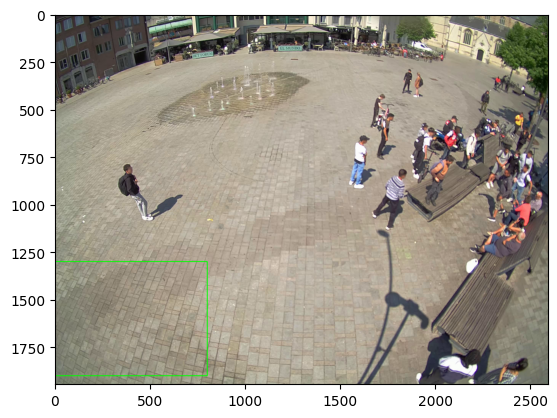

In [15]:
plt.imshow(sample_frame[0])
plt.show()

#### 3.2 Sample clip

Visualize the spatial cropping and temporal segmentation of the video

In [16]:
frame_index = 0 # starting frame index
length = 300 # number of frames to construct the clip
crop_box = [0, 1300, 800, 1900]# xyxyx coordinates of crop

crop_x1, crop_y1, crop_x2, crop_y2 = crop_box

In [17]:
sample_clip = visualize_crop_on_frames(video_path, 
                                       frame_index=frame_index, 
                                       length=length, 
                                       crop=crop_box)
vis_clip = ImageSequenceClip(sample_clip, fps=round(video_info['frame_rate']))

In [18]:
sample_clip[0].shape

(1944, 2592, 3)

In [19]:
#display(vis_clip.ipython_display(fps=round(video_info['frame_rate']), autoplay=True, loop=True))

### 4. Constructing sample video
Here we crop spatially (crop_box) and temporally (frame_index and length) the input video

In [20]:
copped_video = segment_crop_video(video_path, 
                                  frame_index=frame_index, 
                                  length=length, 
                                  crop=crop_box)

In [21]:
len(copped_video), copped_video[0].shape

(300, (600, 800, 3))

In [22]:
crop_height, crop_width = copped_video[0].shape[:2]

In [23]:
crop_height, crop_width

(600, 800)

### 5. Pre-Processing

We pre-process the whole copped video.

In [24]:
from alphaction.dataset.datasets import cv2_transform as cv2_transform


In [25]:
def ava_preprocessing_cv2(sample_cropped_clip, cfg):
    
    
    height, width, _ = sample_cropped_clip[0].shape
    
    imgs, boxes = cv2_transform.random_short_side_scale_jitter(
        sample_cropped_clip,
        min_sizes=cfg.DATA.TEST_MIN_SCALES,
        max_size=cfg.DATA.TEST_MAX_SCALE,
        boxes=None,
    )
    ### imgs: (list, 144, (256, 320, 3))
    ### boxes: None
    
    # Convert image to CHW keeping BGR order.
    imgs = [cv2_transform.HWC2CHW(img) for img in imgs]
    ### imgs: (list, 144, (3, 256, 320))
    
    # Image [0, 255] -> [0, 1].
    imgs = [img / 255.0 for img in imgs]
    
    imgs = [np.ascontiguousarray(
        # img.reshape((3, self._crop_size, self._crop_size))
        img.reshape((3, imgs[0].shape[1], imgs[0].shape[2]))
    ).astype(np.float32) for img in imgs]
    ### imgs: list, 144, (3, 256, 320)
    
    imgs = [
        cv2_transform.color_normalization(
            img,
            np.array(cfg.DATA.MEAN, dtype=np.float32),
            np.array(cfg.DATA.STD, dtype=np.float32),
        )
        for img in imgs
    ]
    ### imgs: list,144, (3, 256, 320), array([-2.,2.4444447, -2.], dtype=float32)    
    
    imgs = np.concatenate([np.expand_dims(img, axis=1) for img in imgs], axis=1)
    ### imgs: numpy.ndarray, (3, 144, 256, 320)
    
    # Convert image format from BGR to RGB.
    if not cfg.AVA.BGR:
        imgs = imgs[::-1, ...]
    ### (3, 144, 256, 320)
    
    imgs = np.ascontiguousarray(imgs)
    
    imgs = torch.from_numpy(imgs)
    ### torch.Size([3, 144, 256, 320])
    
    return imgs
    

In [26]:
prep_video = ava_preprocessing_cv2(copped_video, cfg)

In [27]:
prep_video.shape

torch.Size([3, 300, 256, 341])

In [28]:
prep_height, prep_width = prep_video.shape[-2:]
prep_height, prep_width

(256, 341)

### 6. Constructing clips
We construct the clips using `rate_sample`, and `num_frames`, where `rate_sample` is the sample rate used in constructing the clip and `num_frames` is the length of clip.

In [29]:
def clip_constructor(tensor, rate_sample, num_frames):
    """
    Sample frames from a given tensor with all possible combinations.

    Args:
        tensor (torch.Tensor): Input tensor of shape 3xNxHxW.
        rate_sample (int): Sampling rate.
        num_frames (int): Number of frames in each sampled tensor.

    Returns:
        Tuple: List of sampled tensors, each with shape 3xnum_framesxHxW,
               and list of corresponding center frame indices.
    """
    sampled_tensors = []
    sampled_center_frames = []

    # Calculate the maximum possible starting index
    max_start_index = tensor.size(1) - num_frames * rate_sample + 1
    
    # Iterate over all possible starting indices
    for start_index in range(max_start_index):
        # Extract frames using the specified sampling rate and number of frames
        
        sampled_center_frames.append(int(start_index + rate_sample * num_frames/2))
        
        sampled_frames = tensor[:, start_index:start_index+rate_sample*num_frames:rate_sample, :, :]
        sampled_tensors.append(sampled_frames)
        
    
    return sampled_tensors, sampled_center_frames


In [30]:
prep_clips, center_frames = clip_constructor(prep_video, 
                                             rate_sample=cfg.DATA.SAMPLING_RATE, 
                                             num_frames=cfg.DATA.NUM_FRAMES)

In [31]:
len(prep_clips), prep_clips[0].shape

(253, torch.Size([3, 16, 256, 341]))

In [32]:
prep_height, prep_width = prep_clips[0].shape[-2:]
prep_height, prep_width

(256, 341)

In [33]:
len(center_frames), center_frames[0]

(253, 24)

### 7. Constructing batches

In [34]:
from alphaction.dataset.datasets.utils import pack_pathway_output
pathways = cfg.MODEL.BACKBONE.PATHWAYS
pathways

1

In [35]:
def batch_different_videos(videos, size_divisible=0):
    '''
    :param videos: a list of video tensors
    :param size_divisible: output_size(width and height) should be divisble by this param
    :return: batched videos as a single tensor
    '''
    assert isinstance(videos, (tuple, list))
    max_size = tuple(max(s) for s in zip(*[clip.shape for clip in videos]))

    if size_divisible > 0:
        stride = size_divisible
        max_size = list(max_size)
        max_size[2] = int(math.ceil(max_size[2] / stride) * stride)
        max_size[3] = int(math.ceil(max_size[3] / stride) * stride)
        max_size = tuple(max_size)

    batch_shape = (len(videos),) + max_size
    batched_clips = videos[0].new(*batch_shape).zero_()
    for clip, pad_clip in zip(videos, batched_clips):
        pad_clip[:clip.shape[0], :clip.shape[1], :clip.shape[2], :clip.shape[3]].copy_(clip)

    return batched_clips


In [36]:
if False: # we instead write the rest of dataloader and adding functionality of batch_collator
    from alphaction.dataset.collate_batch import BatchCollator
    batch_collator = BatchCollator(cfg.DATALOADER.SIZE_DIVISIBILITY)

In [37]:
list_collated_batches = []

for idx, clip in enumerate(prep_clips):
    clip_pathways = pack_pathway_output(cfg, clip, pathways=pathways)
    
    if pathways == 1:
        slow, fast = clip_pathways[0], None
    else:
        slow, fast = clip_pathways[0], clip_pathways[1]

    
    h, w = slow.shape[-2:]
    whwh = torch.tensor([w, h, w, h], dtype=torch.float32)
    whwh = whwh.unsqueeze(0)
    
    metadata = ([0, center_frames[idx]], )
    boxes = (None,)
    label_arrs = (None,)
    
    if pathways == 1:
        slow_clip = batch_different_videos([slow], cfg.DATALOADER.SIZE_DIVISIBILITY)
        fast_clip = None
    else:
        slow_clip = batch_different_videos([slow], cfg.DATALOADER.SIZE_DIVISIBILITY)
        fast_clip = batch_different_videos([fast], cfg.DATALOADER.SIZE_DIVISIBILITY)
    
    clip_idx = (idx, )
    list_collated_batches.append([slow_clip, fast_clip, whwh, boxes, label_arrs, metadata, clip_idx])
    
    
    

### 8. Sample Batch

In [38]:
batch = list_collated_batches[0]

In [39]:
slow_clips, fast_clips, whwh, boxes, label_arrs, metadata, clip_ids = batch

In [1]:
slow_clips.shape

NameError: name 'slow_clips' is not defined

In [40]:
clips_height, clips_width = slow_clips.shape[-2:]
clips_height, clips_width 


(256, 352)

In [41]:
slow_clips.shape, slow_clips.dtype, slow_clips.device, slow_clips.requires_grad

(torch.Size([1, 3, 16, 256, 352]), torch.float32, device(type='cpu'), False)

In [42]:
if fast_clips:
    print(fast_clips.shape, fast_clips.dtype, fast_clips.device, fast_clips.requires_grad)
else:
    print(f"fast_clips is None for this config: {config_file}")

fast_clips is None for this config: ../config_files/VMAEv2-ViTB-16x4.yaml


In [43]:
whwh

tensor([[341., 256., 341., 256.]])

In [44]:
whwh.shape, whwh.dtype, whwh.device, whwh.requires_grad


(torch.Size([1, 4]), torch.float32, device(type='cpu'), False)

In [45]:
type(boxes), len(boxes)

(tuple, 1)

In [46]:
type(label_arrs), len(label_arrs)

(tuple, 1)

In [47]:
metadata

([0, 24],)

In [48]:
clip_ids

(0,)

### 9. building model

In [49]:
model = build_detection_model(cfg)

In [50]:
model.to("cuda")

STMDetector(
  (backbone): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): La

### 10. loading weight

In [51]:
output_dir = cfg.OUTPUT_DIR
output_dir

'../output_dir/'

In [52]:
checkpointer = ActionCheckpointer(cfg, model, save_dir=output_dir)
checkpointer.load(cfg.MODEL.WEIGHT)

{}

In [53]:
num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
num_gpus

1

In [54]:
mem_active = cfg.MODEL.STM.MEM_ACTIVE
mem_active  

False

In [55]:
import logging
import os

import torch
from tqdm import tqdm
import time
import datetime

from alphaction.dataset.datasets.evaluation import evaluate
from alphaction.utils.comm import get_rank, is_main_process, all_gather, gather, synchronize, get_world_size
from alphaction.structures.memory_pool import MemoryPool


In [56]:
device = torch.device("cuda")

In [57]:
num_devices = get_world_size()
num_devices

1

In [58]:
model.eval()

STMDetector(
  (backbone): ViT(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): La

In [59]:
mem_active

False

### 11. Inference

In [60]:
len(list_collated_batches), len(center_frames)

(253, 253)

In [61]:
batch = list_collated_batches[0]
center_frame_index = center_frames[0]
center_frame_index

24

In [62]:
def clip_boxes_tensor(boxes, height, width):
    boxes[:, [0, 2]] = torch.clamp(boxes[:, [0, 2]], min=0., max=width-1)
    boxes[:, [1, 3]] = torch.clamp(boxes[:, [1, 3]], min=0., max=height-1)
    return boxes

def map_bbox_from_prep_to_crop(bboxes, original_shape, resized_shape):
    # Calculate scaling factors
    width_scale_factor = original_shape[1] / resized_shape[1]
    height_scale_factor = original_shape[0] / resized_shape[0]
    
    # Map bounding box coordinates to original frame size
    mapped_bboxes = torch.zeros_like(bboxes)
    mapped_bboxes[:, 0] = (bboxes[:, 0] * width_scale_factor).int()
    mapped_bboxes[:, 1] = (bboxes[:, 1] * height_scale_factor).int()
    mapped_bboxes[:, 2] = (bboxes[:, 2] * width_scale_factor).int()
    mapped_bboxes[:, 3] = (bboxes[:, 3] * height_scale_factor).int()
    
    return mapped_bboxes

def map_bbox_from_crop_to_orig(bboxes, crop_position):
    """
    Maps bounding box coordinates from cropped frame to original frame.
    
    Args:
        bboxes (torch.Tensor): Tensor of shape Nx4 containing bounding box coordinates in the cropped frame.
        crop_position (tuple): Tuple containing the (x, y) coordinates of the top-left corner of the cropped frame.
        
    Returns:
        torch.Tensor: Tensor of shape Nx4 containing bounding box coordinates in the original frame.
    """
    # Map bounding box coordinates to original frame size
    mapped_bboxes = torch.zeros_like(bboxes)
    mapped_bboxes[:, 0] = (bboxes[:, 0] + crop_position[0]).int()
    mapped_bboxes[:, 1] = (bboxes[:, 1] + crop_position[1]).int()
    mapped_bboxes[:, 2] = (bboxes[:, 2] + crop_position[0]).int()
    mapped_bboxes[:, 3] = (bboxes[:, 3] + crop_position[1]).int()
    
    return mapped_bboxes

In [63]:
def extract_frame(video_path, frame_index):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file")
        return None
    
    # Set the frame index to the desired frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    
    # Read the frame at the specified frame index
    ret, frame = cap.read()
    
    # Check if frame was read successfully
    if not ret:
        print(f"Error: Unable to read frame at index {frame_index}")
        return None
    
    # Release the video capture object
    cap.release()
    
    return frame

In [64]:
def undo_color_normalization(normalized_tensor, mean, std):
    """
    Undo color normalization.

    Parameters:
    - normalized_tensor: Tensor of shape 3xHxW representing the normalized image.
    - mean: List or tuple of length 3 representing the mean for each channel.
    - std: List or tuple of length 3 representing the standard deviation for each channel.

    Returns:
    - Tensor of shape 3xHxW representing the original image.
    """
    original_tensor = normalized_tensor.clone()

    for i in range(3):
        original_tensor[i, :, :] = (original_tensor[i, :, :] * std[i]) + mean[i]

    return original_tensor

In [65]:
import re

def parse_label_file(file_path):
    # Initialize an empty dictionary to store label_id and label_name pairs
    label_dict = {}

    # Read the contents of the file
    with open(file_path, 'r') as file:
        contents = file.read()

    # Use regular expressions to extract label_id and label_name pairs
    matches = re.findall(r'label \{ name: "(.*?)" label_id: (\d+)', contents)

    # Iterate over the matches and populate the label dictionary
    for label_name, label_id in matches:
        label_dict[int(label_id)] = label_name

    return label_dict

# Example usage:
file_path = 'labels.txt'  # Specify the path to your text file
label_dict = parse_label_file(file_path)
print(label_dict)

{1: 'bend/bow (at the waist)', 2: 'crawl', 3: 'crouch/kneel', 4: 'dance', 5: 'fall down', 6: 'get up', 7: 'jump/leap', 8: 'lie/sleep', 9: 'martial art', 10: 'run/jog', 11: 'sit', 12: 'stand', 13: 'swim', 14: 'walk', 15: 'answer phone', 16: 'brush teeth', 17: 'carry/hold (an object)', 18: 'catch (an object)', 19: 'chop', 20: 'climb (e.g., a mountain)', 21: 'clink glass', 22: 'close (e.g., a door, a box)', 23: 'cook', 24: 'cut', 25: 'dig', 26: 'dress/put on clothing', 27: 'drink', 28: 'drive (e.g., a car, a truck)', 29: 'eat', 30: 'enter', 31: 'exit', 32: 'extract', 33: 'fishing', 34: 'hit (an object)', 35: 'kick (an object)', 36: 'lift/pick up', 37: 'listen (e.g., to music)', 38: 'open (e.g., a window, a car door)', 39: 'paint', 40: 'play board game', 41: 'play musical instrument', 42: 'play with pets', 43: 'point to (an object)', 44: 'press', 45: 'pull (an object)', 46: 'push (an object)', 47: 'put down', 48: 'read', 49: 'ride (e.g., a bike, a car, a horse)', 50: 'row boat', 51: 'sail 


for batch, center_frame_index in zip(list_collated_batches, center_frames):
    
    with torch.no_grad():
        slow_video, fast_video, whwh, boxes, labels, metadata, idx = batch
        slow_video = slow_video.to(device)
        if fast_video is not None:
            fast_video = fast_video.to(device)
        whwh = whwh.to(device)
    
        # INFERENCE
        action_score_list, box_list = model(slow_video, fast_video, whwh, boxes, labels)
        
    output_bbox = box_list[0]
    output_action = action_score_list[0]
    
    output_bbox_inp = output_bbox.clone()
    output_bbox_inp[:, 0] = output_bbox[:, 0] * clips_width
    output_bbox_inp[:, 1] = output_bbox[:, 1] * clips_height
    output_bbox_inp[:, 2] = output_bbox[:, 2] * clips_width
    output_bbox_inp[:, 3] = output_bbox[:, 3] * clips_height

    output_bbox_prep = clip_boxes_tensor(output_bbox_inp, 
                                         height=whwh[0,1], 
                                         width = whwh[0,0])
    
    dec_center_frame = undo_color_normalization(center_frame, cfg.DATA.MEAN, cfg.DATA.STD)
    
    
    
    
    



In [66]:
agg_results_list = []

agg_frames_list = []

for batch, center_frame_index in zip(list_collated_batches, center_frames):
    print(center_frame_index)
    
    with torch.no_grad():

        slow_video, fast_video, whwh, boxes, labels, metadata, idx = batch
        slow_video = slow_video.to(device)
        if fast_video is not None:
            fast_video = fast_video.to(device)
        whwh = whwh.to(device)
    
        # INFERENCE
        action_score_list, box_list = model(slow_video, fast_video, whwh, boxes, labels)
    
    # post-processing
    
    # Removing batch dimension
    output_bbox = box_list[0]
    output_action = action_score_list[0]
    
    # denormalizing bboxes w.r.t. clips shape
    output_bbox_inp = output_bbox.clone()

    output_bbox_inp[:, 0] = output_bbox[:, 0] * clips_width
    output_bbox_inp[:, 1] = output_bbox[:, 1] * clips_height
    output_bbox_inp[:, 2] = output_bbox[:, 2] * clips_width
    output_bbox_inp[:, 3] = output_bbox[:, 3] * clips_height
    
    # clipping bbonx coordinates with prep shape because clip shape is right/bottum padded version of prep shape.
    output_bbox_prep = clip_boxes_tensor(output_bbox_inp, 
                                         height=whwh[0,1], 
                                         width = whwh[0,0])
    
    # Scaling bboxes from prep shape to crop shape
    output_bbox_crop = map_bbox_from_prep_to_crop(output_bbox_prep, 
                                                  (crop_height, crop_width), 
                                                  (prep_height, prep_width))
    
    # mapping from crop to original frame
    output_bbox_frame = map_bbox_from_crop_to_orig(output_bbox_crop , crop_box[:2])
    top_values, top_indices = torch.topk(output_action, k=top_k, dim=1)
    
    output_bbox_frame_np = output_bbox_frame.cpu().numpy()
    top_values_np = top_values.cpu().numpy()
    top_indices_np = top_indices.cpu().numpy()
    
    agg_resutl = np.concatenate((output_bbox_frame_np, top_indices_np, top_values_np), axis=1)
    agg_results_list.append(agg_resutl)
    
    
    cur_frame = extract_frame(video_path, center_frame_index + frame_index)
    
    agg_frames_list.append(cur_frame)
   

24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276


In [67]:
interesting_actions_indices = [5, 64, 71, 75]
interesting_actions_labels = {5:'fall', 64:'fight', 71:'kick', 75:'push'}

vis_frames_list = []
vis_iteresting_frames_list = []


frame_counter = frame_index + center_frames[0] - 1

for sample_result, frame in zip(agg_results_list, agg_frames_list):
    frame_counter += 1
    sample_bbox = sample_result[:, :4]
    sample_top_indices = sample_result[:, 4:9]
    sample_top_values = sample_result[:, 9:]
    
    vis_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
    vis_inter_frame = cv2.cvtColor(frame.copy(), cv2.COLOR_BGR2RGB)
    id_actor = 0
    interesting_frame = False
    for bbox, top_action_indices, top_action_scores in zip(sample_bbox, sample_top_indices, sample_top_values):
        x1, y1, x2, y2 = bbox.astype(int)
        small_text = ''
        
        interesting_actor = False
        for ind, act in enumerate(top_action_indices):
            act += 1 # shifting to ava dataset labeling
            if act in interesting_actions_indices:
                interesting_actor = True
                interesting_frame = True
                
                small_text += '{}_{}'.format(interesting_actions_labels[act], 
                                             np.round(top_action_scores[ind], 2))
        if interesting_actor:
            long_text = '{}:'.format(id_actor) # add ID of actor for frame visualization
            for act, score in zip(top_action_indices, top_action_scores):
                long_text += '{}_{}-'.format(label_dict[act+1].replace('(', '').replace(')', '').split('/')[0], 
                                             (np.round(score, 2)))
                
        
        if interesting_actor:
            # plot the bbox of interesting actor and adding interesting action
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(vis_frame, small_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            cv2.rectangle(vis_inter_frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            #id_text = '{}:{}'.format(id_actor, small_text)
            id_text = '{}'.format(id_actor)
            id_actor += 1

            cv2.putText(vis_inter_frame, id_text, (x1+10, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2)
            cv2.putText(vis_inter_frame, str(frame_counter), (40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 4)
            
            # add text containing all actions of interesting actor
            if crop_box[1] <= original_height/2:
                cv2.putText(vis_inter_frame, 
                            long_text[:-1], 
                            (20, original_height - 100 + 20 * id_actor), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            else:
                cv2.putText(vis_inter_frame, 
                            long_text[:-1], 
                            (20, 100 + 20 * id_actor), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            
            
        else:
            # plot the bbox of other actors
            cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.rectangle(vis_inter_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
    
    cv2.rectangle(vis_frame, (crop_box[0], crop_box[1]), (crop_box[2], crop_box[3]), (255, 255, 0), 2)
    cv2.rectangle(vis_inter_frame, (crop_box[0], crop_box[1]), (crop_box[2], crop_box[3]), (255, 255, 0), 2)
    
    
    vis_frames_list.append(vis_frame)
    if interesting_frame:
        vis_iteresting_frames_list.append(vis_inter_frame)
        frame_path = os.path.join(output_directory, f"frame_{frame_counter}.jpg")
        cv2.imwrite(frame_path, cv2.cvtColor(vis_inter_frame, cv2.COLOR_BGR2RGB))
        
    
        
    

    

    

In [ ]:
plt.imshow(vis_iteresting_frames_list[-20])

In [ ]:
frame_path

In [ ]:
vis_clip_output = ImageSequenceClip(vis_frames_list, fps=round(video_info['frame_rate']))

In [ ]:
display(vis_clip_output.ipython_display(fps=round(video_info['frame_rate']), autoplay=True, loop=True))

In [ ]:
sample_frame = agg_frames_list[80]
sample_result = agg_results_list[80]



sample_bbox = sample_result[:, :4]
sample_top_indices = sample_result[:, 4:9]
sample_top_values = sample_result[:, 9:]

In [ ]:
interesting_actions_indices = [5, 64, 71, 75]
interesting_actions_labels = {5:'fall', 64:'fight', 71:'kick', 75:'push'}


In [ ]:
vis_frame = sample_frame.copy()
for bbox, top_action_indices, top_action_scores in zip(sample_bbox, sample_top_indices, sample_top_values):
    x1, y1, x2, y2 = bbox.astype(int)
    text = ''
    found = False
    for ind, act in enumerate(top_action_indices):
        act += 1 # shifting to ava dataset labeling
        if act in interesting_actions_indices:
            found = True
            text += '{}_{}'.format(interesting_actions_labels[act], np.round(top_action_scores[ind], 2))
    if found:
        cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(vis_frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        

In [ ]:
plt.imshow(vis_frame)

In [ ]:
np.round(top_action_scores[0], 2)

In [ ]:
type(box_list), len(box_list), box_list[0].shape, box_list[0]

In [ ]:
type(action_score_list), len(action_score_list), action_score_list[0].shape# action_score_list[0]

#### 11.1 Removing batch dimension

In [ ]:
output_bbox = box_list[0]

In [ ]:
output_action = action_score_list[0]

#### 11.2 Denormalizing bbonx coordinates with clips shape

In [ ]:
clips_height, clips_width 

In [ ]:
output_bbox_inp = output_bbox.clone()

output_bbox_inp[:, 0] = output_bbox[:, 0] * clips_width
output_bbox_inp[:, 1] = output_bbox[:, 1] * clips_height
output_bbox_inp[:, 2] = output_bbox[:, 2] * clips_width
output_bbox_inp[:, 3] = output_bbox[:, 3] * clips_height


In [ ]:
output_bbox_inp

#### 11.3 clipping bbonx coordinates with prep shape

Here, we do clipping bbox coordinates with shape of preprocessed frames, i.e., un-padded frame.

In [ ]:
whwh

In [ ]:
def clip_boxes_tensor(boxes, height, width):
    boxes[:, [0, 2]] = torch.clamp(boxes[:, [0, 2]], min=0., max=width-1)
    boxes[:, [1, 3]] = torch.clamp(boxes[:, [1, 3]], min=0., max=height-1)
    return boxes

In [ ]:
output_bbox_prep = clip_boxes_tensor(output_bbox_inp, 
                                     height=whwh[0,1], 
                                     width = whwh[0,0])

In [ ]:
output_bbox_prep.shape

#### 11.4 Mapping bbox coordinates to crop 


In [ ]:
def map_bbox_to_original_frame(bboxes, original_shape, resized_shape):
    # Calculate scaling factors
    width_scale_factor = original_shape[1] / resized_shape[1]
    height_scale_factor = original_shape[0] / resized_shape[0]
    
    # Map bounding box coordinates to original frame size
    mapped_bboxes = torch.zeros_like(bboxes)
    mapped_bboxes[:, 0] = (bboxes[:, 0] * width_scale_factor).int()
    mapped_bboxes[:, 1] = (bboxes[:, 1] * height_scale_factor).int()
    mapped_bboxes[:, 2] = (bboxes[:, 2] * width_scale_factor).int()
    mapped_bboxes[:, 3] = (bboxes[:, 3] * height_scale_factor).int()
    
    return mapped_bboxes

In [ ]:
output_bbox_crop = map_bbox_to_original_frame(output_bbox_prep, (crop_height, crop_width), (prep_height, prep_width))

#### 11.5 Mapping bbox coordinates to original frame shape

In [ ]:
def map_bbox_to_original_frame(bboxes, crop_position):
    """
    Maps bounding box coordinates from cropped frame to original frame.
    
    Args:
        bboxes (torch.Tensor): Tensor of shape Nx4 containing bounding box coordinates in the cropped frame.
        crop_position (tuple): Tuple containing the (x, y) coordinates of the top-left corner of the cropped frame.
        
    Returns:
        torch.Tensor: Tensor of shape Nx4 containing bounding box coordinates in the original frame.
    """
    # Map bounding box coordinates to original frame size
    mapped_bboxes = torch.zeros_like(bboxes)
    mapped_bboxes[:, 0] = (bboxes[:, 0] + crop_position[0]).int()
    mapped_bboxes[:, 1] = (bboxes[:, 1] + crop_position[1]).int()
    mapped_bboxes[:, 2] = (bboxes[:, 2] + crop_position[0]).int()
    mapped_bboxes[:, 3] = (bboxes[:, 3] + crop_position[1]).int()
    
    return mapped_bboxes

In [ ]:
output_bbox_frame = map_bbox_to_original_frame(output_bbox_crop , crop_box[:2])

In [ ]:
output_bbox_frame

In [ ]:
crop_box

In [ ]:
center_frame_index

In [ ]:
frame_index

In [ ]:
center_frame_index + frame_index

In [ ]:
def extract_frame(video_path, frame_index):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    # Check if the video file opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video file")
        return None
    
    # Set the frame index to the desired frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
    
    # Read the frame at the specified frame index
    ret, frame = cap.read()
    
    # Check if frame was read successfully
    if not ret:
        print(f"Error: Unable to read frame at index {frame_index}")
        return None
    
    # Release the video capture object
    cap.release()
    
    return frame

frame = extract_frame("../input_dir/fight_prison_youtube.mp4", center_frame_index + frame_index)

In [ ]:
# Transfer data to CPU and convert to NumPy arrays
bboxes_cpu = output_bbox_frame.cpu().numpy()
vis_frame = frame.copy()

# Draw bounding boxes on the image
for bbox in bboxes_cpu:
    x1, y1, x2, y2 = bbox.astype(int)
    print(x1)
    cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [ ]:
plt.imshow(vis_frame)

In [ ]:
# Number of top elements to retrieve
top_k = 5

# Get the top k values and indices along the last dimension (dimension 1)
top_values, top_indices = torch.topk(action_score_list[0], k=top_k, dim=1)

In [ ]:
top_values.shape

In [ ]:
interesting_actions_indices = [5, 64, 71, 75]
interesting_actions_labels = {5:'fall', 64:'fight', 71:'kick', 75:'push'}


In [ ]:
# Draw bounding boxes on the image
vis_frame = frame.copy()
for bbox, top_action_indices, top_action_scores in zip(bboxes_cpu, top_indices, top_values):
    x1, y1, x2, y2 = bbox.astype(int)
    top_indices_np = top_action_indices.cpu().numpy()
    top_values_np = top_action_scores.cpu().numpy()
    text = ''
    found = False
    for ind, act in enumerate(top_indices_np):
        act += 1 # shifting to ava dataset labeling
        if act in interesting_actions_indices:
            found = True
            text += '{}'.format(interesting_actions_labels[act])
    if found:
        cv2.rectangle(vis_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(vis_frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        

In [ ]:
plt.imshow(vis_frame)

In [ ]:
action_score_list[0].shape

In [ ]:
crop_box

In [ ]:
prep_height

In [ ]:
center_frame = prep_video[:,center_frame_index,:,:]

In [ ]:
center_frame.dtype

In [ ]:
center_frame.shape

In [ ]:
center_frame[:,0,0]

In [ ]:
def undo_color_normalization(normalized_tensor, mean, std):
    """
    Undo color normalization.

    Parameters:
    - normalized_tensor: Tensor of shape 3xHxW representing the normalized image.
    - mean: List or tuple of length 3 representing the mean for each channel.
    - std: List or tuple of length 3 representing the standard deviation for each channel.

    Returns:
    - Tensor of shape 3xHxW representing the original image.
    """
    original_tensor = normalized_tensor.clone()

    for i in range(3):
        original_tensor[i, :, :] = (original_tensor[i, :, :] * std[i]) + mean[i]

    return original_tensor

In [ ]:
dec_center_frame = undo_color_normalization(center_frame, cfg.DATA.MEAN, cfg.DATA.STD)

In [ ]:
dec_center_frame[:,:,:]

In [ ]:
output_bbox_prep.shape

In [ ]:
# Transfer data to CPU and convert to NumPy arrays
image_cpu = dec_center_frame.cpu().numpy().transpose(1, 2, 0)
bboxes_cpu = output_bbox_prep.cpu().numpy()

# Convert image to uint8
# Convert image to uint8
image_cpu_uint8 = (image_cpu * 255).astype(np.uint8).copy()
# Scale bounding boxes to image size

# Draw bounding boxes on the image
for bbox in bboxes_cpu:
    x1, y1, x2, y2 = bbox.astype(int)
    print(x1)
    cv2.rectangle(image_cpu_uint8, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [ ]:
plt.imshow(image_cpu_uint8)
plt.show()

In [ ]:
action_score_list[0]

In [ ]:
# Number of top elements to retrieve
top_k = 5

# Get the top k values and indices along the last dimension (dimension 1)
top_values, top_indices = torch.topk(action_score_list[0], k=top_k, dim=1)

# Access the values and indices for each row
for i in range(action_score_list[0].shape[0]):
    row_values = top_values[i].cpu().numpy()
    row_indices = top_indices[i].cpu().numpy()
    print(f"Row {i + 1}: Top Values: {row_values}, Top Indices: {row_indices+1}")


In [ ]:
bboxes_cpu.shape

In [ ]:
# Transfer data to CPU and convert to NumPy arrays
image_cpu = dec_center_frame.cpu().numpy().transpose(1, 2, 0)
bboxes_cpu = output_bbox_prep.cpu().numpy()

# Convert image to uint8
# Convert image to uint8
image_cpu_uint8 = (image_cpu * 255).astype(np.uint8).copy()
# Scale bounding boxes to image size

interesting_actions_indices = [5, 64, 71, 75]
interesting_actions_labels = {5:'fall', 64:'fight', 71:'kick', 75:'push'}



# Draw bounding boxes on the image
for bbox, top_action_indices, top_action_scores in zip(bboxes_cpu, top_indices, top_values):
    x1, y1, x2, y2 = bbox.astype(int)
    top_indices_np = top_action_indices.cpu().numpy()
    top_values_np = top_action_scores.cpu().numpy()
    text = ''
    found = False
    for ind, act in enumerate(top_indices_np):
        act += 1
        if act in interesting_actions_indices:
            found = True
            text += '{}'.format(interesting_actions_labels[act])
    if found:
        cv2.rectangle(image_cpu_uint8, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image_cpu_uint8, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        
    
            
        
     
    #cv2.rectangle(image_cpu_uint8, (x1, y1), (x2, y2), (0, 255, 0), 2)

In [ ]:
plt.imshow(image_cpu_uint8)
plt.show()

In [ ]:
65 in top_action_indices

item { name: "bend/bow (at the waist)" id: 1 } 
item { name: "crouch/kneel" id: 3 } 
item { name: "dance" id: 4 } 
item { name: "fall down" id: 5 } 
item { name: "get up" id: 6 } 
item { name: "jump/leap" id: 7 } 
item { name: "lie/sleep" id: 8 } 
item { name: "martial art" id: 9 } 
item { name: "run/jog" id: 10 } 
item { name: "sit" id: 11 } 
item { name: "stand" id: 12 } 
item { name: "swim" id: 13 } 
item { name: "walk" id: 14 } 
item { name: "answer phone" id: 15 } 
item { name: "carry/hold (an object)" id: 17 } 
item { name: "climb (e.g., a mountain)" id: 20 } 
item { name: "close (e.g., a door, a box)" id: 22 } 
item { name: "cut" id: 24 } 
item { name: "dress/put on clothing" id: 26 } 
item { name: "drink" id: 27 } 
item { name: "drive (e.g., a car, a truck)" id: 28 } 
item { name: "eat" id: 29 } 
item { name: "enter" id: 30 } 
item { name: "hit (an object)" id: 34 } 
item { name: "lift/pick up" id: 36 } 
item { name: "listen (e.g., to music)" id: 37 } 
item { name: "open (e.g., a window, a car door)" id: 38 } 
item { name: "play musical instrument" id: 41 } 
item { name: "point to (an object)" id: 43 } 
item { name: "pull (an object)" id: 45 } 
item { name: "push (an object)" id: 46 } 
item { name: "put down" id: 47 } 
item { name: "read" id: 48 } 
item { name: "ride (e.g., a bike, a car, a horse)" id: 49 } 
item { name: "sail boat" id: 51 } 
item { name: "shoot" id: 52 } 
item { name: "smoke" id: 54 } 
item { name: "take a photo" id: 56 } 
item { name: "text on/look at a cellphone" id: 57 } 
item { name: "throw" id: 58 } 
item { name: "touch (an object)" id: 59 } 
item { name: "turn (e.g., a screwdriver)" id: 60 } 
item { name: "watch (e.g., TV)" id: 61 } 
item { name: "work on a computer" id: 62 } 
item { name: "write" id: 63 } 
item { name: "fight/hit (a person)" id: 64 } 
item { name: "give/serve (an object) to (a person)" id: 65 } 
item { name: "grab (a person)" id: 66 } 
item { name: "hand clap" id: 67 } 
item { name: "hand shake" id: 68 } 
item { name: "hand wave" id: 69 } 
item { name: "hug (a person)" id: 70 } 
item { name: "kiss (a person)" id: 72 } 
item { name: "lift (a person)" id: 73 } 
item { name: "listen to (a person)" id: 74 } 
item { name: "push (another person)" id: 76 } 
item { name: "sing to (e.g., self, a person, a group)" id: 77 } 
item { name: "take (an object) from (a person)" id: 78 } 
item { name: "talk to (e.g., self, a person, a group)" id: 79 } 
item { name: "watch (a person)" id: 80 }

In [ ]:
action_score_list[0][0].shape

In [ ]:
import re

def parse_label_file(file_path):
    # Initialize an empty dictionary to store label_id and label_name pairs
    label_dict = {}

    # Read the contents of the file
    with open(file_path, 'r') as file:
        contents = file.read()

    # Use regular expressions to extract label_id and label_name pairs
    matches = re.findall(r'label \{ name: "(.*?)" label_id: (\d+)', contents)

    # Iterate over the matches and populate the label dictionary
    for label_name, label_id in matches:
        label_dict[int(label_id)] = label_name

    return label_dict

# Example usage:
file_path = 'labels.txt'  # Specify the path to your text file
label_dict = parse_label_file(file_path)
print(label_dict)

In [ ]:
height, width, _ = sample_cropped_clip[0].shape

height, width # (360, 486)

In [ ]:
from alphaction.dataset.datasets import cv2_transform as cv2_transform

imgs, boxes = cv2_transform.random_short_side_scale_jitter(
    sample_cropped_clip,
    min_sizes=self_jitter_min_scale,
    max_size=self_jitter_max_scale,
    boxes=None,
)

In [ ]:
type(imgs), len(imgs), imgs[0].shape

In [ ]:
boxes

In [ ]:
# Convert image to CHW keeping BGR order.
imgs = [cv2_transform.HWC2CHW(img) for img in imgs]

In [ ]:
imgs[0].shape # (3, 256, 346)

In [ ]:
# Image [0, 255] -> [0, 1].
imgs = [img / 255.0 for img in imgs]

In [ ]:
imgs = [np.ascontiguousarray(
    # img.reshape((3, self._crop_size, self._crop_size))
    img.reshape((3, imgs[0].shape[1], imgs[0].shape[2]))
).astype(np.float32) for img in imgs]

In [ ]:
type(imgs), len(imgs), imgs[0].shape # (list, 144, (3, 256, 320))

In [ ]:
imgs = [
            cv2_transform.color_normalization(
                img,
                np.array(self_data_mean, dtype=np.float32),
                np.array(self_data_std, dtype=np.float32),
            )
            for img in imgs
        ]

In [ ]:
type(imgs), len(imgs), imgs[0].shape, imgs[0][:,0,0]

In [ ]:
imgs = np.concatenate(
            [np.expand_dims(img, axis=1) for img in imgs], axis=1
        )


In [ ]:
type(imgs), imgs.shape # (numpy.ndarray, (3, 144, 256, 320)

In [ ]:
self_use_bgr

In [ ]:
if not self_use_bgr:
    # Convert image format from BGR to RGB.
    imgs = imgs[::-1, ...]

In [ ]:
imgs.shape # (3, 16, 256, 346)

In [ ]:
imgs = np.ascontiguousarray(imgs)

In [ ]:
imgs.shape # (3, 144, 256, 320)

In [ ]:
imgs = torch.from_numpy(imgs)

In [ ]:
imgs.shape

In [ ]:
def sample_frames(tensor, rate_sample, num_frames):
    """
    Sample frames from a given tensor with all possible combinations.

    Args:
        tensor (torch.Tensor): Input tensor of shape 3xNxHxW.
        rate_sample (int): Sampling rate.
        num_frames (int): Number of frames in each sampled tensor.

    Returns:
        List of sampled tensors, each with shape 3xnum_framesxHxW.
    """
    sampled_tensors = []

    # Calculate the maximum possible starting index
    max_start_index = tensor.size(1) - num_frames * rate_sample + 1
    
    # Iterate over all possible starting indices
    for start_index in range(max_start_index):
        # Extract frames using the specified sampling rate and number of frames
        sampled_frames = tensor[:, start_index:start_index+rate_sample*num_frames:rate_sample, :, :]
        sampled_tensors.append(sampled_frames)

    return sampled_tensors


In [ ]:
sampled_frames = sample_frames(imgs, rate_sample = 3, num_frames = 16)

In [ ]:
len(sampled_frames)

In [ ]:
sampled_frames[0].shape

In [ ]:
from alphaction.dataset.datasets.utils import pack_pathway_output

In [ ]:
pathways = cfg.MODEL.BACKBONE.PATHWAYS

In [ ]:
list_batches = []
for idx, clip in enumerate(sampled_frames):
    clip_pathways = pack_pathway_output(cfg, clip, pathways=pathways)
    if pathways == 1:
        slow, fast = clip_pathways[0], None
    else:
        slow, fast = clip_pathways[0], clip_pathways[1]
    
    h, w = slow.shape[-2:]
    whwh = torch.tensor([w, h, w, h], dtype=torch.float32)
    metadata = [0, 0]
    boxes = None
    label_arrs = None
    
    batch = [slow, fast, whwh, boxes, label_arrs, metadata, idx]
    list_batches.append(batch)
    
    

In [ ]:
batch = list_batches[0]

In [ ]:
transposed_batch = list(zip(*list_batches))

In [ ]:
len(transposed_batch[0])

In [ ]:
transposed_batch[0][0].shape

In [ ]:
from alphaction.dataset.collate_batch import BatchCollator

In [ ]:
batch_collator = BatchCollator(cfg.DATALOADER.SIZE_DIVISIBILITY)

In [ ]:
slow_clips, fast_clips, whwh, boxes, label_arrs, metadata, clip_ids = batch_collator(list_batches)

In [ ]:
slow_clips[0].shape

In [ ]:
whwh[0]

In [ ]:
from alphaction.dataset.datasets.utils import pack_pathway_output

In [ ]:
pathways = cfg.MODEL.BACKBONE.PATHWAYS

In [ ]:
pathways

In [ ]:
sampled_frames = pack_pathway_output(cfg, imgs, pathways=pathways)

In [ ]:
type(sampled_frames), len(sampled_frames)

In [ ]:
type(sampled_frames[0])

In [ ]:
sampled_frames[0][0]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class YourDataset(Dataset):
    def __init__(self):
        # Your dataset initialization here
        pass

    def __len__(self):
        # Return the total number of samples in your dataset
        return 1

    def __getitem__(self, index):
        # Your dataset loading logic here
        # For illustration purposes, I'll use random tensors
        tensor_shape = (3, 16, 256, 320)
        tensor = torch.rand(tensor_shape)
        tensor_four = torch.rand(4)
        list_of_length_2 = [1, 2]

        return tensor, tensor_four, list_of_length_2

# Create an instance of your dataset
dataset = YourDataset()

# Create a DataLoader with batch_size = 1
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate through the dataloader
for batch in dataloader:
    print("Batch Shape:", batch)


In [ ]:
batch[0].shape

In [ ]:
batch[1].shape

In [ ]:
batch[2][0].shape

In [ ]:
selected_idx = scores[0] >= self.person_threshold
new_scores = scores[0][selected_idx]